In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset

In [2]:
PAD_token = 0  
SOS_token = 1 
EOS_token = 2

In [3]:
from __future__ import absolute_import

from torch.jit import script, trace
import csv
import codecs
import itertools
import math

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def get_dialog_pairs(dataset):
    dataset_length = len(dataset)
    dialog_pairs = []
    for i in range(dataset_length - 1):
        conv_length = len(dataset[i])
        for j in range(1,conv_length):
            if isinstance(dataset[i][j-1], str):
                inputLine = dataset[i][j-1].strip()
            else:
                inputLine = dataset[i][j-1]['text'].strip() 
            if not isinstance(inputLine, str): 
                inputLine = 'None'
            if isinstance(dataset[i][j], str):
                targetLine = dataset[i][j].strip()
            else:
                targetLine = dataset[i][j]['text'].strip() 
            if not isinstance(targetLine, str): 
                targetLine = 'None'
            if isinstance(inputLine, str) and isinstance(targetLine, str):
                dialog_pairs.append([inputLine, targetLine])
        #print(i)
    return dialog_pairs

In [6]:
PAD_token = 0  
SOS_token = 1 
EOS_token = 2

In [7]:
def create_index_to_vec(word_to_id, glovefile): 
    lines = open(glovefile, 'r', encoding='utf-8').readlines()
    id_to_vec = {}
    vector = None
    
    for line in lines:
        word = line.split()[0]
        vector = np.array(line.split()[1:], dtype='float32') #32
        
        if word in word_to_id:
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(vector))
            
    for word, id in word_to_id.items(): 
        if word_to_id[word] not in id_to_vec:
            v = np.zeros(*vector.shape, dtype='float32')
            v[:] = np.random.randn(*v.shape)*0.01
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(v))
    
    return id_to_vec

In [8]:
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.index2vec = None
        self.num_words = 3

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [9]:
MAX_LENGTH = 10
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [10]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [11]:
def append_retrieval_result(pair, num_responses):
    %run -i retrieval_model_response.py
    response = get_response_sample(pair[0], num_responses)
    response = response[0]
    new_pair = pair[1] + ' ' + response
    return [pair[0], new_pair]

In [12]:
def readVocs(dataset, dataset1, name):
    dialog_pairs = get_dialog_pairs(dataset)
    dialog_pairs1 = get_dialog_pairs(dataset1)
    dialog_pairs.extend(dialog_pairs1)
    # Normalize
    pairs = [[normalizeString(s) for s in l] for l in dialog_pairs]
    voc = Voc(name)
    return voc, pairs

In [13]:
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

In [14]:
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [15]:
def prepareData(name):
    # Get sentences
    print("Start preparing training data ...")
    raw_dataset = load_dataset("conv_ai_2")
    raw_dataset1 = load_dataset("daily_dialog")
    train_dataset = raw_dataset["train"]
    train_dataset1 = raw_dataset1["train"]
    dialog_dataset = train_dataset["dialog"]
    dialog_dataset1 = train_dataset1["dialog"]
    voc, pairs = readVocs(dialog_dataset, dialog_dataset1, name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    f_pairs = []
    for pair in pairs:
        if not isinstance(pair[0], str) or not pair[0]:
            continue
        if not isinstance(pair[1], str) or not pair[1]:
            continue
        f_pairs.append([pair[0], pair[1]])
    
    # Calculate retrieval result for each pair, will take several hours
    ret_pairs = [append_retrieval_result(pair, 500) for pair in pairs]
    
    print("Trimmed to {!s} sentence pairs".format(len(f_pairs)))
    print("Counting words...")
    for pair in f_pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, f_pairs

save_dir = os.path.join("C:\\Users\\justi\\Downloads", "save1")
d_name = "convai2_set"
model_name = "seq2seq-retrieval"
# Load/Assemble voc and pairs
voc, pairs = prepareData(d_name)

Start preparing training data ...


Reusing dataset conv_ai_2 (C:\Users\justi\.cache\huggingface\datasets\conv_ai_2\conv_ai_2\1.0.0\11d600ddce66bb9d07ca50d1b55b488145ef0d5d0206168c32f1043677875865)
Using custom data configuration default
Reusing dataset daily_dialog (C:\Users\justi\.cache\huggingface\datasets\daily_dialog\default\1.0.0\c03444008e9508b8b76f1f6793742d37d5e5f83364f8d573c2747bff435ea55c)


KeyboardInterrupt: 

In [46]:
def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
MIN_COUNT = 1
pairs = trimRareWords(voc, pairs, MIN_COUNT)
embedding_dim = 200
voc.index2vec = create_index_to_vec(voc.word2index, 'saveDir/GloVe/glove.6B.%dd.txt' %embedding_dim)

Trimmed from 34700 pairs to 34700, 1.0000 of total


In [15]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):    
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)
        
        self.init_weights()
            
    def init_weights(self):
        nn.init.uniform(self.gru.weight_ih_l0, a = -0.01, b = 0.01)
        nn.init.orthogonal(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0.requires_grad = True
        self.gru.weight_hh_l0.requires_grad = True
        embedding_weights = torch.FloatTensor(voc.num_words, self.hidden_size)
        embedding_weights = embedding_weights.to(device)
        for id, vec in voc.index2vec.items():
            embedding_weights[id] = vec
        
        self.embedding.weight = nn.Parameter(embedding_weights, requires_grad = True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [17]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [18]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)
        
        self.init_weights()
            
    def init_weights(self):
        nn.init.uniform(self.gru.weight_ih_l0, a = -0.01, b = 0.01)
        nn.init.orthogonal(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0.requires_grad = True
        self.gru.weight_hh_l0.requires_grad = True
        embedding_weights = torch.FloatTensor(voc.num_words, self.hidden_size)
        embedding_weights = embedding_weights.to(device)
        for id, vec in voc.index2vec.items():
            embedding_weights[id] = vec
        
        self.embedding.weight = nn.Parameter(embedding_weights, requires_grad = True)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [19]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [20]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [21]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    loss_list = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1
        loss_list = checkpoint['loss_list']

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            loss_list.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, d_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss_list': loss_list,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [ ]:
# Configure models
model_name = 'model'
attn_model = 'concat'
hidden_size = 200
encoder_n_layers = 3
decoder_n_layers = 3
dropout = 0.1
batch_size = 64

#loadFilename = None
checkpoint_iter = 25000
loadFilename = os.path.join(save_dir, model_name, d_name,
                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    print('Loading saved checkpoint')
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    loss_list = checkpoint['loss_list']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']
    


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

In [118]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 80000
print_every = 500
save_every = 5000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, d_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 30500; Percent complete: 61.0%; Average loss: 1.1223
Iteration: 31000; Percent complete: 62.0%; Average loss: 1.1065
Iteration: 31500; Percent complete: 63.0%; Average loss: 1.0885
Iteration: 32000; Percent complete: 64.0%; Average loss: 1.0739
Iteration: 32500; Percent complete: 65.0%; Average loss: 1.0511
Iteration: 33000; Percent complete: 66.0%; Average loss: 1.0383
Iteration: 33500; Percent complete: 67.0%; Average loss: 1.0243
Iteration: 34000; Percent complete: 68.0%; Average loss: 1.0088
Iteration: 34500; Percent complete: 69.0%; Average loss: 0.9864
Iteration: 35000; Percent complete: 70.0%; Average loss: 0.9813
Iteration: 35500; Percent complete: 71.0%; Average loss: 0.9691
Iteration: 36000; Percent complete: 72.0%; Average loss: 0.9544
Iteration: 36500; Percent complete: 73.0%; Average loss: 0.9450
Iteration: 37000; Percent complete: 74.0%; Average loss: 0.9260
Iteration: 37500; Percent comple

In [21]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [22]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            #output_words[0] = output_words[0].upper()
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words).capitalize())

        except KeyError:
            print("Error: Encountered unknown word.")


In [27]:
# Configure models
model_name = 'model'
attn_model = 'concat'
save_dir = os.path.join("C:\\Users\\justi\\Downloads", "save1")
d_name = "convai2_set"
hidden_size = 200
encoder_n_layers = 3
decoder_n_layers = 3
dropout = 0.1
batch_size = 64
voc = Voc('temp')

#loadFilename = None
checkpoint_iter = 25000
loadFilename = os.path.join(save_dir, model_name, d_name,
                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    print('Loading saved checkpoint')
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    loss_list = checkpoint['loss_list']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']
    


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Loading saved checkpoint
Building encoder and decoder ...


<ipython-input-15-8c5ce3cbbfde>:16: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.gru.weight_ih_l0, a = -0.01, b = 0.01)
<ipython-input-15-8c5ce3cbbfde>:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.gru.weight_hh_l0)
<ipython-input-17-b1a3538159b0>:24: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.gru.weight_ih_l0, a = -0.01, b = 0.01)
<ipython-input-17-b1a3538159b0>:25: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.gru.weight_hh_l0)


Models built and ready to go!


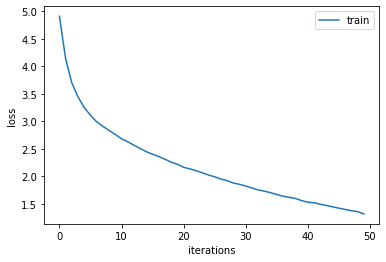

In [30]:
plt.plot(loss_list, label='train')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

>  Hello


Bot: Hi how are you doing ? ?


>  Hi


Bot: Hi how are you doing ? a day


>  What music do you like


Bot: I like rap music . ?


>  How are you


Bot: I am doing well . here


>  Do you play sports


Bot: I do not . i like to eat .


>  What sports do you like


Bot: I like to read and surf .


>  Do you have hobbies


Bot: I like to listen to music classical music


>  Do you have a job


Bot: I do i am a activist . ?


>  What is your job


Bot: I am a professional gardener .
